In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [30]:
data = pd.read_csv('/content/data.csv')

In [31]:
print(data.head())
data.info()

                category  room_count  bathroom_count   size      type  \
0     Terrains et Fermes        -1.0            -1.0   -1.0  À Vendre   
1     Terrains et Fermes        -1.0            -1.0   -1.0  À Vendre   
2           Appartements         2.0             1.0   80.0   À Louer   
3  Locations de vacances         1.0             1.0   90.0   À Louer   
4           Appartements         2.0             2.0  113.0  À Vendre   

      price    city         region  log_price  
0  100000.0  Ariana         Raoued   5.000000  
1  316000.0  Ariana  Autres villes   5.499687  
2     380.0  Ariana  Autres villes   2.579784  
3      70.0  Ariana  Autres villes   1.845098  
4  170000.0  Ariana   Ariana Ville   5.230449  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12748 entries, 0 to 12747
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   category        12748 non-null  object 
 1   room_count      12748 non

In [32]:
data.shape

(12748, 9)

In [33]:
# Vérification des valeurs nulles
null_counts = data.isnull().sum()
print("Total des valeurs nulles :", null_counts.sum())

# Vérification des valeurs négatives
rows_with_negatives = (data == -1).any(axis=1).sum()
print("Nombre de lignes contenant -1 :", rows_with_negatives)

# Vérification des valeurs dupliquées
duplicate_counts = data.duplicated().sum()
print("Nombre de valeurs dupliquées :", duplicate_counts)

# Remplacer les -1 par des valeurs nulles et supprimer les lignes contenant des nulls
cdata = data.replace(-1, np.nan)
cdata = cdata.dropna()
print(cdata.shape)

# Vérification des valeurs dupliquées restantes
print(cdata.duplicated().sum())

# Suppression des doublons en conservant la première occurrence
cdata = cdata.drop_duplicates(keep='first')

print(cdata.shape)



Total des valeurs nulles : 0
Nombre de lignes contenant -1 : 3415
Nombre de valeurs dupliquées : 1613
(9333, 9)
805
(8528, 9)


In [34]:
# Suppression des colonnes non numériques (categories et types)
nmdata = cdata.select_dtypes(include=[np.number])

nmdata = nmdata.dropna()

# Suppression de la colonne log_price
data = nmdata.drop(columns=['price'])

# Normalisation des données
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


In [35]:
# Initialisation et application de l'ACP
pca = PCA()
pca_components = pca.fit_transform(data_scaled)

In [36]:
# Calcul des valeurs propres (variance expliquée)
explained_variance = pca.explained_variance_ratio_

# Affichage des variances expliquée
print("Variance expliquée par chaque composante :", explained_variance)

Variance expliquée par chaque composante : [0.56170263 0.19434057 0.14367616 0.10028063]


In [37]:

eig = pd.DataFrame({
    "Dimension": ["Dim" + str(x + 1) for x in range(len(pca.explained_variance_))],
    "Variance expliquée": pca.explained_variance_,
    "% variance expliquée": np.round(pca.explained_variance_ratio_ * 100, 2),
    "% cum. var. expliquée": np.round(np.cumsum(pca.explained_variance_ratio_) * 100, 2)
})

# Affichage du tableau
print(eig)

  Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0      Dim1            2.247074                 56.17                  56.17
1      Dim2            0.777453                 19.43                  75.60
2      Dim3            0.574772                 14.37                  89.97
3      Dim4            0.401170                 10.03                 100.00


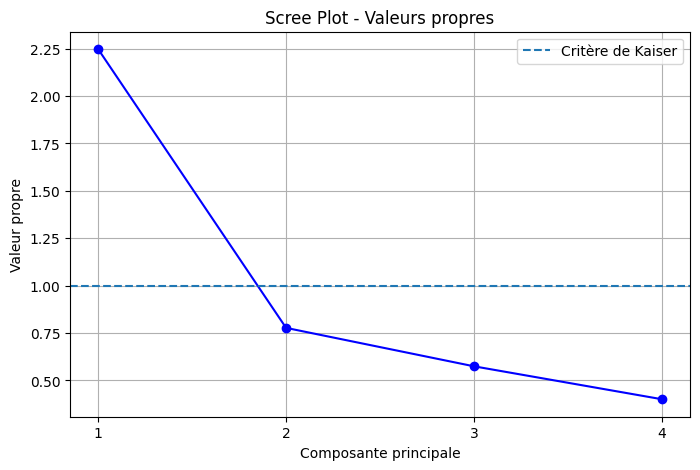

In [38]:
# Valeurs propres
eigenvalues = pca.explained_variance_

# Scree Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o', color='b')
plt.axhline(y=1, linestyle='--', label='Critère de Kaiser')

plt.title("Scree Plot - Valeurs propres")
plt.xlabel("Composante principale")
plt.ylabel("Valeur propre")
plt.xticks(range(1, len(eigenvalues)+1))
plt.legend()
plt.grid(True)

plt.show()

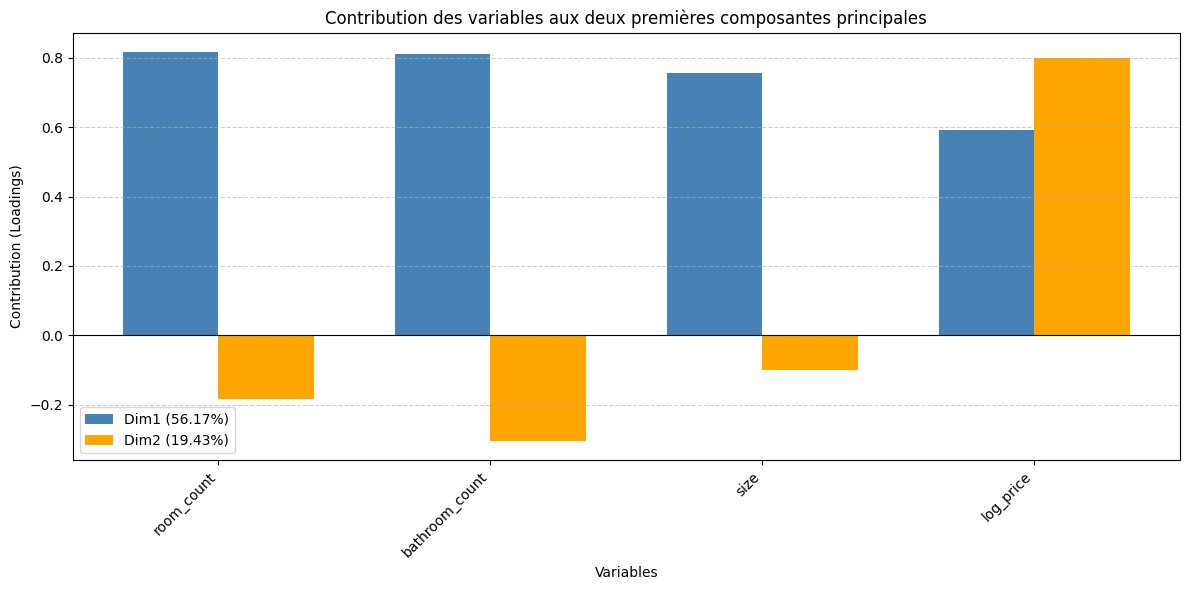

In [39]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Use data columns (numeric only, same data PCA was fitted on)
variable_names = data.columns.tolist()
n_vars = len(variable_names)

x = np.arange(n_vars)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - width/2, loadings[:, 0], width,
       label=f'Dim1 ({eig["% variance expliquée"][0]}%)', color='steelblue')
ax.bar(x + width/2, loadings[:, 1], width,
       label=f'Dim2 ({eig["% variance expliquée"][1]}%)', color='orange')

ax.set_xticks(x)
ax.set_xticklabels(variable_names, rotation=45, ha='right')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_xlabel("Variables")
ax.set_ylabel("Contribution (Loadings)")
ax.set_title("Contribution des variables aux deux premières composantes principales")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

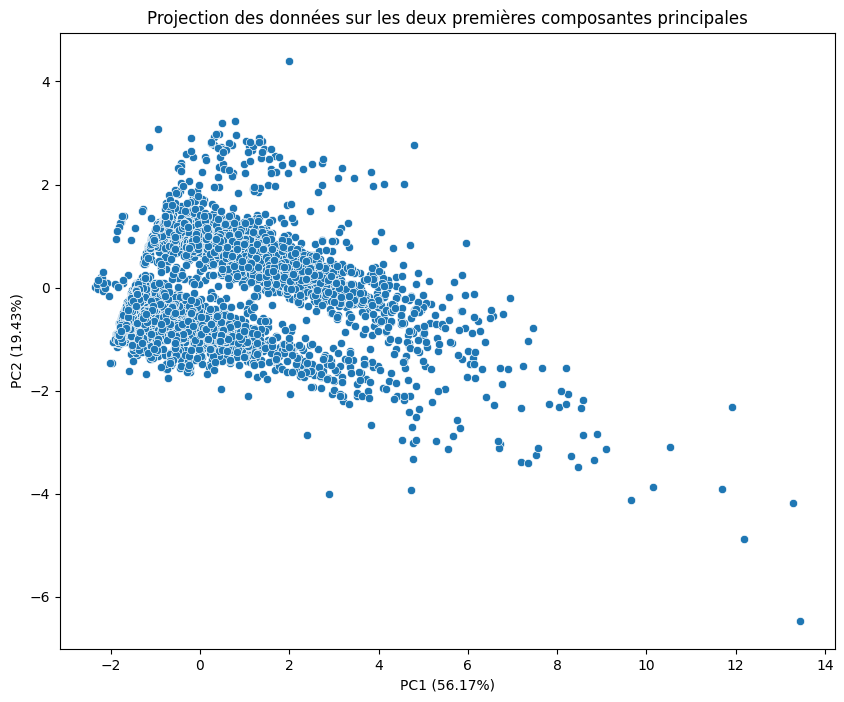

In [40]:
# Création d'un DataFrame pour les deux premières composantes principales
pca_df = pd.DataFrame(pca_components[:, :2], columns=['PC1', 'PC2'])

# Visualisation de la projection
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('Projection des données sur les deux premières composantes principales')
plt.xlabel(f'PC1 ({eig["% variance expliquée"][0]}%)')
plt.ylabel(f'PC2 ({eig["% variance expliquée"][1]}%)')
plt.show()

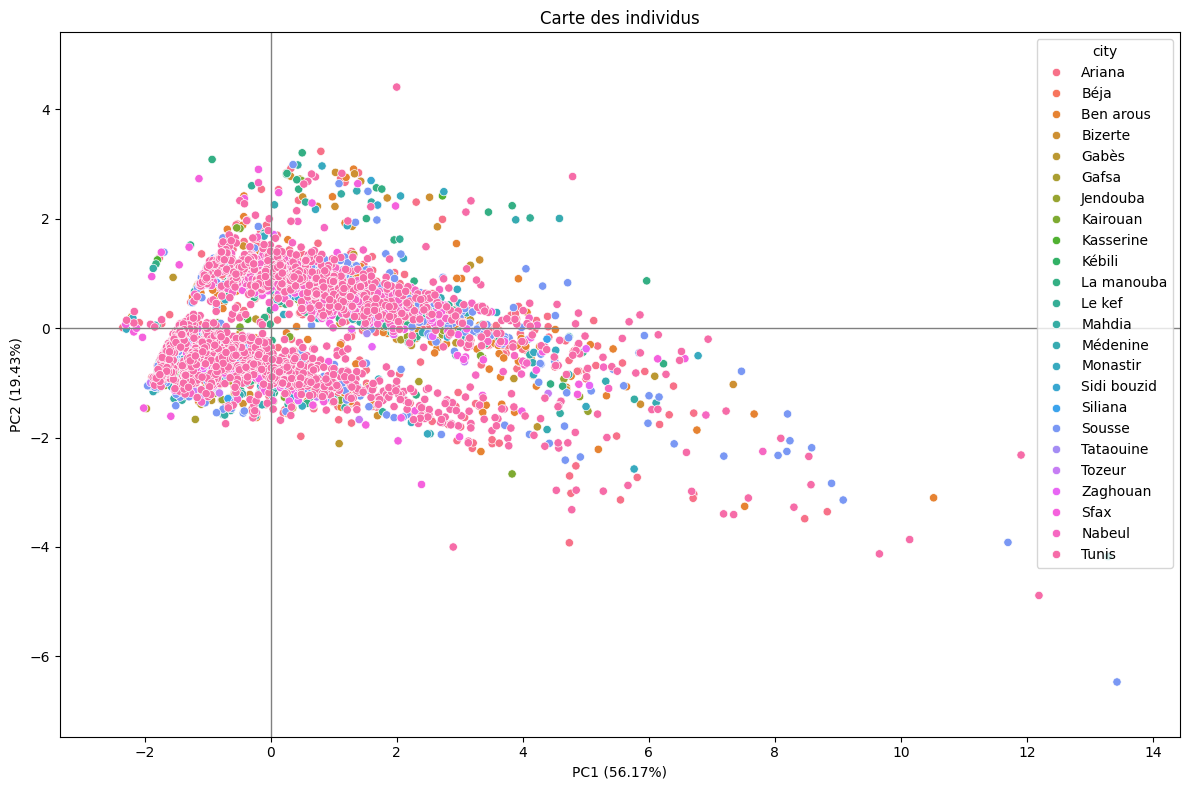

In [41]:
# Ajout de la colonne 'city' pour identifier les points
pca_df['city'] = nmdata['city'].values if 'city' in nmdata.columns else cdata['city'].values

# Visualisation
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue='city', legend='brief')

# Axes au centre
plt.axhline(0, color='grey', linewidth=1)
plt.axvline(0, color='grey', linewidth=1)

# Limites des axes
plt.xlim(pca_df['PC1'].min() - 1, pca_df['PC1'].max() + 1)
plt.ylim(pca_df['PC2'].min() - 1, pca_df['PC2'].max() + 1)

# Etiquettes et titre
plt.xlabel(f'PC1 ({eig["% variance expliquée"][0]}%)')
plt.ylabel(f'PC2 ({eig["% variance expliquée"][1]}%)')
plt.title("Carte des individus")

plt.tight_layout()
plt.show()

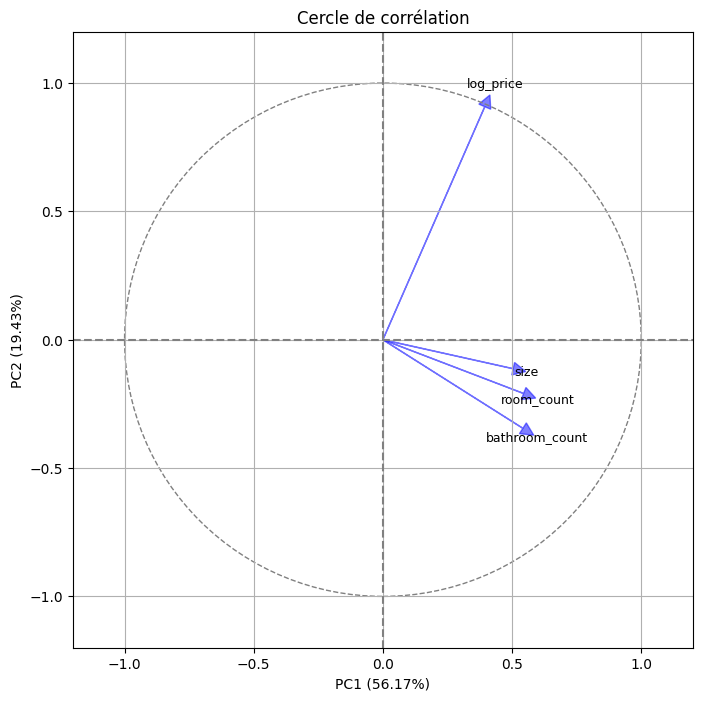

In [42]:
# Coordonnées des variables dans le plan formé par PC1 et PC2
pcs = pca.components_
x_vector = pcs[0, :]
y_vector = pcs[1, :]

# Cercle de corrélation
plt.figure(figsize=(8, 8))
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')

# Tracé des flèches pour chaque variable et affichage du nom de chaque variable
for i in range(len(data.columns)):
    plt.arrow(0, 0, x_vector[i], y_vector[i], color='b', alpha=0.5,
              head_width=0.05, head_length=0.05)
    plt.text(x_vector[i] * 1.1, y_vector[i] * 1.1, data.columns[i], color='black',
             ha='center', va='center', fontsize=9)

# Cercle
plt.gca().add_artist(plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--'))
plt.xlabel(f'PC1 ({eig["% variance expliquée"][0]}%)')
plt.ylabel(f'PC2 ({eig["% variance expliquée"][1]}%)')
plt.title("Cercle de corrélation")
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.grid()
plt.show()